1. Import Libraries / Dependencies

In [5]:
import cv2
import numpy as np
from itertools import chain
import csv
import os
import keras.models as models

In [6]:
from cvzone.HandTrackingModule import HandDetector
from cvzone.FaceDetectionModule import FaceDetector
from cvzone.PoseModule import PoseDetector

2. Hand, Face and Pose Detection + Feature Extraction

In [7]:
def flatten2dList(arr, dataType=int):
    return np.fromiter(chain.from_iterable(arr), dataType)

In [8]:
def getAbsLargestVal(arr):
    return max(np.max(arr), abs(np.min(arr)))

In [9]:
def preprocess_landmarks(landmark_list):
    if not landmark_list:
        return []
    
    # Offset every point with respect to the first point
    new_landmark_list = []
    origin_x = landmark_list[0][0] 
    origin_y = landmark_list[0][1]
    origin_z = landmark_list[0][2]
    for each in landmark_list:
        updated_point = [
            each[0] - origin_x, 
            each[1] - origin_y, 
            each[2] - origin_z
        ]
        new_landmark_list.append(updated_point)
    
    # Convert to 1D-array
    new_landmark_list = flatten2dList(new_landmark_list)
    
    # Get highest absolute value
    largest_value = getAbsLargestVal(new_landmark_list)
    
    # Normalization
    return new_landmark_list / largest_value


In [11]:
def preprocess_bbox(bbox, frameSize):
    bbox = np.array(bbox, dtype=float)
    # Convert 3rd and 4th element into coordinates instead of width/height
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]

    # Normalize against frame size
    bbox[0] /= frameSize[0]
    bbox[2] /= frameSize[0]
    bbox[1] /= frameSize[1]
    bbox[3] /= frameSize[1]

    return bbox

In [12]:
def preprocess_center(center, frameSize):
    center = np.array(center)
    center[0] /= frameSize[0]
    center[1] /= frameSize[1]
    return center

In [13]:
def preprocess_body_part(bodyPart, frameSize):
    bodyPart['lmList'] = preprocess_landmarks(bodyPart['lmList'])
    bodyPart['bbox'] = preprocess_bbox(bodyPart['bbox'], frameSize)
    bodyPart['center'] = preprocess_center(bodyPart['center'], frameSize)
    return bodyPart

In [14]:
def generate_empty_hand(type):
    return {
        'lmList': np.zeros(21 * 3, dtype=int), 
        'bbox': np.zeros(4, dtype=float), 
        'center': np.zeros(2, dtype=float), 
        'type': type
    }

In [15]:
def select_best_matching_face(faces, frameSize):
    if not faces:
        return False
    elif len(faces) == 1:
        return faces[0]
    
    def difference(a, b):
        return (a[0] - b[0])**2 + (a[1] - b[1])**2
    
    frameCenter = (frameSize[0] / 2, frameSize[1] / 2)

    best_score = faces[0]
    best_center = faces[0]
    center_diff = difference(faces[0]['center'], frameCenter)

    for each in faces:
        if difference(each['center'], frameCenter) < center_diff:
            best_center = each
        if each['score'][0] > best_score['score'][0]:
            best_score = each
    
    if best_center['score'][0] > 0.5:
        return best_center
    return best_score

In [16]:
def flattenDetectionResult(obj):
    return np.concatenate([obj['lmList'], obj['bbox'], obj['center']])

Prototype of pose detection

In [28]:
cam = cv2.VideoCapture(0)

# Detectors
handDetector = HandDetector(detectionCon=0.5, maxHands=2)
faceDetector = FaceDetector(minDetectionCon=0.5)
poseDetector = PoseDetector(detectionCon=0.5)

try:
    while True:
        # Read from camera
        success, frame = cam.read()
        if not success:
            break

        results = {}
        frameSize = (frame.shape[1], frame.shape[0])

        # Hand Detection
        results['hands'], frame = handDetector.findHands(frame, draw=True)
        if not results['hands']:
            results['hands'] = [generate_empty_hand('Left'), generate_empty_hand('Right')]
        elif len(results['hands']) == 1:
            if (results['hands'][0]['type'] == 'Left'):
                results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
                results['hands'].append(generate_empty_hand('Right'))
            else:
                results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
                results['hands'].insert(0, generate_empty_hand('Left'))                         
        else:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'][1] = preprocess_body_part(results['hands'][1], frameSize)

        # Pose Detection
        # * We only use the first 23 out of the total 33 landmark points 
        #   as those represent the lower half body and are irrelevant
        frame = poseDetector.findPose(frame, draw=True)
        results['pose'] = {}
        results['pose']['lmList'], tempPoseBbox = poseDetector.findPosition(frame, bboxWithHands=False)
        if results['pose']['lmList'] and tempPoseBbox:
            results['pose']['lmList'] = results['pose']['lmList'][:23]
            results['pose']['bbox'] = tempPoseBbox['bbox']
            results['pose']['center'] = tempPoseBbox['center']
            results['pose'] = preprocess_body_part(results['pose'], frameSize)
        else:
            results['pose']['lmList'] = np.zeros(23 * 3, dtype=int)
            results['pose']['bbox'] = np.zeros(4, dtype=float)
            results['pose']['center'] = np.zeros(2, dtype=float)
            
        # Face Detection
        frame, results['face'] = faceDetector.findFaces(frame, draw=True)
        if results['face']:
            results['face'] = select_best_matching_face(results['face'], frameSize)
            results['face']['bbox'] = preprocess_bbox(results['face']['bbox'], frameSize)
            results['face']['center'] = preprocess_center(results['face']['center'], frameSize)
        else:
            results['face'] = {
                'bbox': np.zeros(4, dtype=float), 
                'center': np.zeros(2, dtype=float)
            }

        # Convert results into 1D-array
        detectionResults = np.concatenate([
            flattenDetectionResult(results['hands'][0]), 
            flattenDetectionResult(results['hands'][1]), 
            flattenDetectionResult(results['pose']), 
            results['face']['bbox'], 
            results['face']['center']
        ])

        # Show frame
        cv2.imshow("Sign Language Recognition Prototype", frame)

        keyPressed = cv2.waitKey(10)
        if (keyPressed == ord('q')):
            pass

        # Pressed 'Esc'
        if (keyPressed == 27):
            break

except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    raise e

cam.release()
cv2.destroyAllWindows()

Each output is now a 219 length 1D-array

In [29]:
detectionResults

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

3. Preparation for Data Collection

In [17]:
STATIC_LABELS_PATH = os.path.join('../static-recognition/static-labels.csv')
static_labels = []
with open(STATIC_LABELS_PATH) as f:
    csv_static_reader = csv.reader(f, delimiter=",")
    static_labels = [each[1] for each in csv_static_reader]
static_labels

['A', 'B', 'C']

In [18]:
# Initialize data paths
STATIC_KEYPOINTS_PATH = os.path.join("../static-recognition/keypoints_data")
for static_label in static_labels:
    if not os.path.exists(os.path.join(STATIC_KEYPOINTS_PATH, static_label)):
        os.makedirs(os.path.join(STATIC_KEYPOINTS_PATH, static_label))

4. Data Collection

In [20]:
# Detects hands, face & pose, 
# convert them into normalized landmark/keypoint coordinates in a 1D-array, 
# and also returns the frame with the landmark connections drawn onto it
def featureExtraction(handDetector, faceDetector, poseDetector, frame):
    results = {}
    frameSize = (frame.shape[1], frame.shape[0])

    # Hand Detection
    results['hands'], frame = handDetector.findHands(frame, draw=True)
    if not results['hands']:
        results['hands'] = [generate_empty_hand('Left'), generate_empty_hand('Right')]
    elif len(results['hands']) == 1:
        if (results['hands'][0]['type'] == 'Left'):
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'].append(generate_empty_hand('Right'))
        else:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'].insert(0, generate_empty_hand('Left'))                         
    else:
        results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
        results['hands'][1] = preprocess_body_part(results['hands'][1], frameSize)

    # Pose Detection
    # * We only use the first 23 out of the total 33 landmark points 
    #   as those represent the lower half body and are irrelevant
    frame = poseDetector.findPose(frame, draw=True)
    results['pose'] = {}
    results['pose']['lmList'], tempPoseBbox = poseDetector.findPosition(frame, bboxWithHands=False)
    if results['pose']['lmList'] and tempPoseBbox:
        results['pose']['lmList'] = results['pose']['lmList'][:23]
        results['pose']['bbox'] = tempPoseBbox['bbox']
        results['pose']['center'] = tempPoseBbox['center']
        results['pose'] = preprocess_body_part(results['pose'], frameSize)
    else:
        results['pose']['lmList'] = np.zeros(23 * 3, dtype=int)
        results['pose']['bbox'] = np.zeros(4, dtype=float)
        results['pose']['center'] = np.zeros(2, dtype=float)
        
    # Face Detection
    frame, results['face'] = faceDetector.findFaces(frame, draw=True)
    if results['face']:
        results['face'] = select_best_matching_face(results['face'], frameSize)
        results['face']['bbox'] = preprocess_bbox(results['face']['bbox'], frameSize)
        results['face']['center'] = preprocess_center(results['face']['center'], frameSize)
    else:
        results['face'] = {
            'bbox': np.zeros(4, dtype=float), 
            'center': np.zeros(2, dtype=float)
        }

    # Convert results into 1D-array
    detectionResults = np.concatenate([
        flattenDetectionResult(results['hands'][0]), 
        flattenDetectionResult(results['hands'][1]), 
        flattenDetectionResult(results['pose']), 
        results['face']['bbox'], 
        results['face']['center']
    ])

    return detectionResults, frame

In [21]:
# Detects hands, face & pose, 
# convert them into normalized landmark/keypoint coordinates in a 1D-array, 
# and also returns the frame with the landmark connections drawn onto it
def handFeatureExtraction(handDetector, frame):
    results = {}
    frameSize = (frame.shape[1], frame.shape[0])

    # Hand Detection
    results['hands'], frame = handDetector.findHands(frame, draw=True)
    if not results['hands']:
        results['hands'] = [generate_empty_hand('Left'), generate_empty_hand('Right')]
    elif len(results['hands']) == 1:
        if (results['hands'][0]['type'] == 'Left'):
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'].append(generate_empty_hand('Right'))
        else:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'].insert(0, generate_empty_hand('Left'))                         
    else:
        results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
        results['hands'][1] = preprocess_body_part(results['hands'][1], frameSize)

    # Convert results into 1D-array
    detectionResults = np.concatenate([
        flattenDetectionResult(results['hands'][0]), 
        flattenDetectionResult(results['hands'][1]), 
    ])

    return detectionResults, frame

In [22]:
def readFrame():
    success, frame = cam.read()
    if not success: 
        raise Exception("No Frames Read")
    return cv2.flip(frame, 1)
    

def countdownFromThree(trainingNum, actionStr):
    # Count down 3 seconds on every new training
    for i in range(3):
        for _ in range(10):
            frame = readFrame()
            cv2.putText(frame, f'Training #{trainingNum + 1} for \'{actionStr}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            cv2.putText(frame, f'Next Training in {3 - i}', (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
            cv2.imshow("Sign Language Recognition Prototype", frame)
            tempKey = cv2.waitKey(100)
            if (tempKey == 27):
                raise Exception("Finished")
            elif tempKey == 32:
                pauseWhenSpace(trainingNum, actionStr)
                return

def pauseWhenSpace(trainingNum, actionStr):
    while True:                
        frame = readFrame()
        cv2.putText(frame, f'Training #{trainingNum + 1} for \'{actionStr}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        cv2.putText(frame, f'Pausing...', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (20, 255, 125), 3)
        cv2.imshow("Sign Language Recognition Prototype", frame)

        # If pressed resume, do countdown
        keyPressed = cv2.waitKey(100)
        if keyPressed == 32:
            resume = False
            for i in range(3):
                for _ in range(10):
                    temp_frame = readFrame()
                    cv2.putText(temp_frame, f'Training #{trainingNum + 1} for \'{actionStr}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                    cv2.putText(temp_frame, f'Resuming in {3 - i}', (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 120), 3)
                    cv2.imshow("Sign Language Recognition Prototype", temp_frame)
                    tempKey = cv2.waitKey(100)
                    if (tempKey == 27):
                        raise Exception("Finished")
                    # If pressed paused again, stop resuming and continue pausing
                    elif tempKey == 32:
                        resume = True
                        break
                if resume:
                    break
            if not resume:
                return
            
        elif keyPressed == 27:
            raise Exception("Finished")

In [23]:
trainings_per_label = 10

In [24]:
# # save each data in different file
# from time import time
# cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
# cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# # Detectors
# handDetector = HandDetector(detectionCon=0.5, maxHands=2)
# faceDetector = FaceDetector(minDetectionCon=0.5)
# poseDetector = PoseDetector(detectionCon=0.5)

# startTime = time()

# try:
#     # manual change number to specify the character to train
#     static_label = static_labels[0]
#     i = 0

#     while True:
#         trainingResults = []

#         # Read from camera
#         frame = readFrame()

#         detectionResults, frame = handFeatureExtraction(
#             handDetector, frame)

#         # Show resulting frame
#         cv2.putText(frame, f'Training for \'{static_label}\'',
#                     (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
#         cv2.imshow("Sign Language Recognition Prototype", frame)

#         keyPressed = cv2.waitKey(10)
#         # Stop Program when pressed 'Esc'
#         if (keyPressed == 27):
#             raise Exception("Finished")
#         elif (keyPressed == ord('s')):
#             trainingResults.append(detectionResults)
#             # IMPORTANT: THIS LINE IS DISABLED IN CASE OF ACCIDENTALLY OVERWRITING DATA
#             # Renable it ONLY during data collection
#             i += 1
#             np.save(os.path.join(STATIC_KEYPOINTS_PATH,
#                     static_label, str(static_label)+str(i)), np.array(trainingResults))

# # After all frames are finished for each training:
# # save as .npy


# except Exception as e:
#     cam.release()
#     cv2.destroyAllWindows()
#     print(e)

# cam.release()
# cv2.destroyAllWindows()


In [37]:
# save all data in 1 file
from time import time
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Detectors
handDetector = HandDetector(detectionCon=0.5, maxHands=2)

try:
    # manual change number to specify the character to train
    static_label = static_labels[2]
    trainingResults = np.empty((0, 138), dtype=float)  # Initialize as an empty array
    save_path = os.path.join(STATIC_KEYPOINTS_PATH, f"{static_label}.npy")
    if(os.path.exists(save_path)):
        trainingResults = np.load(save_path)
    
    while True:
        # Read from camera
        frame = readFrame()

        detectionResults, frame = handFeatureExtraction(handDetector, frame)

        # Show resulting frame
        cv2.putText(frame, f'Training for \'{static_label}\'',
                    (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        cv2.imshow("Sign Language Recognition Prototype", frame)

        keyPressed = cv2.waitKey(10)
        # Stop Program when pressed 'Esc'
        if (keyPressed == 27):
            # Save the trainingResults array as .npy file
            np.save(os.path.join(STATIC_KEYPOINTS_PATH, static_label, f"{static_label}.npy"), trainingResults)
            raise Exception("Finished")
        elif (keyPressed == ord('s')):
            # Append the detectionResults as a new row to trainingResults
            trainingResults = np.vstack((trainingResults, detectionResults))
            print(trainingResults)  

except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    print(e)

cam.release()
cv2.destroyAllWindows()

Finished


In [25]:
cam.release()
cv2.destroyAllWindows()

NameError: name 'cam' is not defined

In [27]:
np.load(os.path.join(STATIC_KEYPOINTS_PATH,
                    str(static_label) + '.npy')).shape

(64, 138)

## Static Recognition Model Training & Testing

1. Preprocess Data

In [2]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [19]:
static_mapping = {}
with open(STATIC_LABELS_PATH) as f:
    csv_reader = csv.reader(f, delimiter=",")
    static_mapping = {each[1]: each[0] for each in csv_reader}
    
static_mapping

{'A': '0', 'B': '1', 'C': '2'}

In [28]:
features, labels = [], []

# get the label name and retrieve npy file
for static_label in static_labels:
    sequence = np.load(os.path.join(STATIC_KEYPOINTS_PATH, str(static_label) + '.npy'))
    for i in range(len(sequence)):
        # Add the individual data from npy
        features.append(sequence[i])
        # add the label of the data (index)  
        labels.append(static_mapping[static_label])

print(len(features))
print(len(labels))
print(features)
print(labels)

149
149
[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.      

In [43]:
X = np.array(features)
X.shape

(149, 138)

In [44]:
y = to_categorical(labels).astype(int)
y.shape

(149, 3)

In [45]:
X.nbytes

164496

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(111, 138)
(38, 138)
(111, 3)
(38, 3)


2. Model Compiling

In [48]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [49]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))

model.add(Flatten())

# Dense layers for translation (ANN)
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final output layer
model.add(Dense(len(static_labels), activation='softmax'))  # 3 output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 136, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 68, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 33, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 31, 128)           24704     
                                                                 
 flatten (Flatten)           (None, 3968)              0

3. Model Training

In [50]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
4/4 [==============================] - 1s 19ms/step - loss: 0.4930 - accuracy: 0.7477
Epoch 2/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 3/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 0s 19ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 0s 19ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 0s 19ms/step - loss: 9.1261e-04 - accuracy: 1.0000
Epoch 8/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 9/30
4/4 [==============================] - 0s 19ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/30
4/4 [==============================] - 0s 19ms/step - loss: 6.6159e-04 - accuracy: 1.0000
Epoch 11/30
4/4 [====

In [51]:
MODEL_PATH = os.path.join("../static-recognition/models/static_model.h5")
model = models.load_model(MODEL_PATH)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 136, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 68, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 64)            6208      
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 dense (Dense)               (None, 128)               540800    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

4. Model Testing

In [52]:
test_results = model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


In [53]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [54]:
y_actual = np.argmax(y_test, axis=1)
y_predict = np.argmax(test_results, axis=1)

In [55]:
accuracy_score(y_actual, y_predict)

1.0

In [56]:
multilabel_confusion_matrix(y_actual, y_predict)

array([[[30,  0],
        [ 0,  8]],

       [[27,  0],
        [ 0, 11]],

       [[19,  0],
        [ 0, 19]]], dtype=int64)

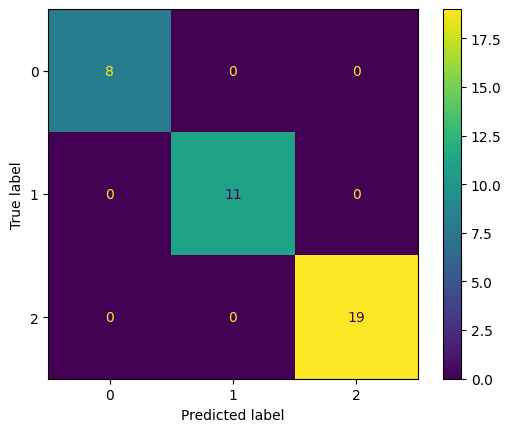

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(y_actual, y_predict)
cmDisp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmDisp.plot()
plt.show()

5. Saving Model Weights

In [58]:
MODEL_PATH = os.path.join("../static-recognition/models")

In [59]:
model.save(os.path.join(MODEL_PATH, "static_model.h5"))

c:\Users\Eng Lip\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Real Time Testing

In [60]:
from collections import deque
from concurrent.futures import ThreadPoolExecutor
from time import time
from cvzone import FPS

In [61]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Detectors
handDetector = HandDetector(detectionCon=0.5, maxHands=2)
faceDetector = FaceDetector(minDetectionCon=0.5)
poseDetector = PoseDetector(detectionCon=0.5)

fpsReader = FPS()

timeStats = []

try:

    keypointsHistory = deque()
    predictionHistory = deque()
    detectionThreshold = 1.0

    lastPredictionTime = time()
    predictionCooldown = 1

    while True:
        startTime = time()

        # Read from camera
        success, frame = cam.read()
        if not success:
            raise Exception("No Frames Read")
        frame = cv2.flip(frame, 1)

        # Pose Detection
        detectionResults, frame = handFeatureExtraction(
            handDetector, frame)

        detectionResults = np.expand_dims(
            detectionResults, axis=0)  # Reshape to (1, 138, 3)

        predictionResults = model.predict(
            x=detectionResults,
            verbose=0,
            use_multiprocessing=True,
            workers=4
        )[0]

        predCharacter = static_labels[np.argmax(predictionResults)]
        predAccuracy = predictionResults[np.argmax(predictionResults)]
        print(predictionResults)

        cv2.putText(frame, ', '.join(predCharacter), (15, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

        fps, frame = fpsReader.update(frame, pos=(
            950, 80), color=(0, 255, 0), scale=5, thickness=5)

        # Show resulting frame
        # cv2.putText(frame, f'Training #{training + 1} for \'{action}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        cv2.imshow("Sign Language Recognition Prototype", frame)

        timeStats.append(time() - startTime)

        keyPressed = cv2.waitKey(1)
        # Stop Program when pressed 'Esc'
        if (keyPressed == 27):
            raise Exception("Finished")


except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    print(e)

cam.release()
cv2.destroyAllWindows()


[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339   0.00367905]
[0.08598195 0.910339

In [62]:
timeStats[10:]

[0.08566474914550781,
 0.10086894035339355,
 0.10375642776489258,
 0.09979367256164551,
 0.09605741500854492,
 0.10675954818725586,
 0.10607337951660156,
 0.08356356620788574,
 0.11075949668884277,
 0.08996129035949707,
 0.09297370910644531,
 0.10557413101196289,
 0.1035470962524414,
 0.0924992561340332,
 0.0945887565612793,
 0.10864520072937012,
 0.12564539909362793,
 0.09201741218566895,
 0.09353256225585938,
 0.08751726150512695,
 0.10343718528747559,
 0.08470559120178223,
 0.10269808769226074,
 0.098602294921875,
 0.13814306259155273,
 0.10355496406555176,
 0.10494184494018555,
 0.10354161262512207,
 0.1079411506652832,
 0.10440683364868164,
 0.12957119941711426,
 0.11556553840637207,
 0.10358476638793945,
 0.10344123840332031,
 0.10658001899719238,
 0.1076347827911377,
 0.1229395866394043,
 0.10496282577514648,
 0.10612964630126953,
 0.10365104675292969,
 0.12175202369689941,
 0.10804343223571777,
 0.11755084991455078,
 0.10457038879394531,
 0.10854482650756836,
 0.104291677474975